In [2]:
import pandas as pd

# Load the comprehensive dataset
df = pd.read_csv("/orcd/data/omarabu/001/njwfish/counting_flows/results/comparison/DeconvolutionGaussianMixtureDataset_dim4_3da39a67.csv")
print(f"Dataset shape: {df.shape}")
print(f"Unique group sizes (n): {sorted(df['group_size_mean'].unique())}")
print(f"Unique Dirichlet concentrations: {sorted(df['dirichlet_concentration_mean'].unique())}")
print(f"Unique lambda values: {sorted(df['uniform_lambda_mean'].unique())}")

Dataset shape: (12, 63)
Unique group sizes (n): [np.float64(4.0), np.float64(8.0), np.float64(32.0), np.float64(128.0)]
Unique Dirichlet concentrations: [np.float64(1.0), np.float64(10.0), np.float64(1000.0)]
Unique lambda values: [np.float64(1.0)]


Creating line plots for each metric...
Creating line plot for mmd_rbf...


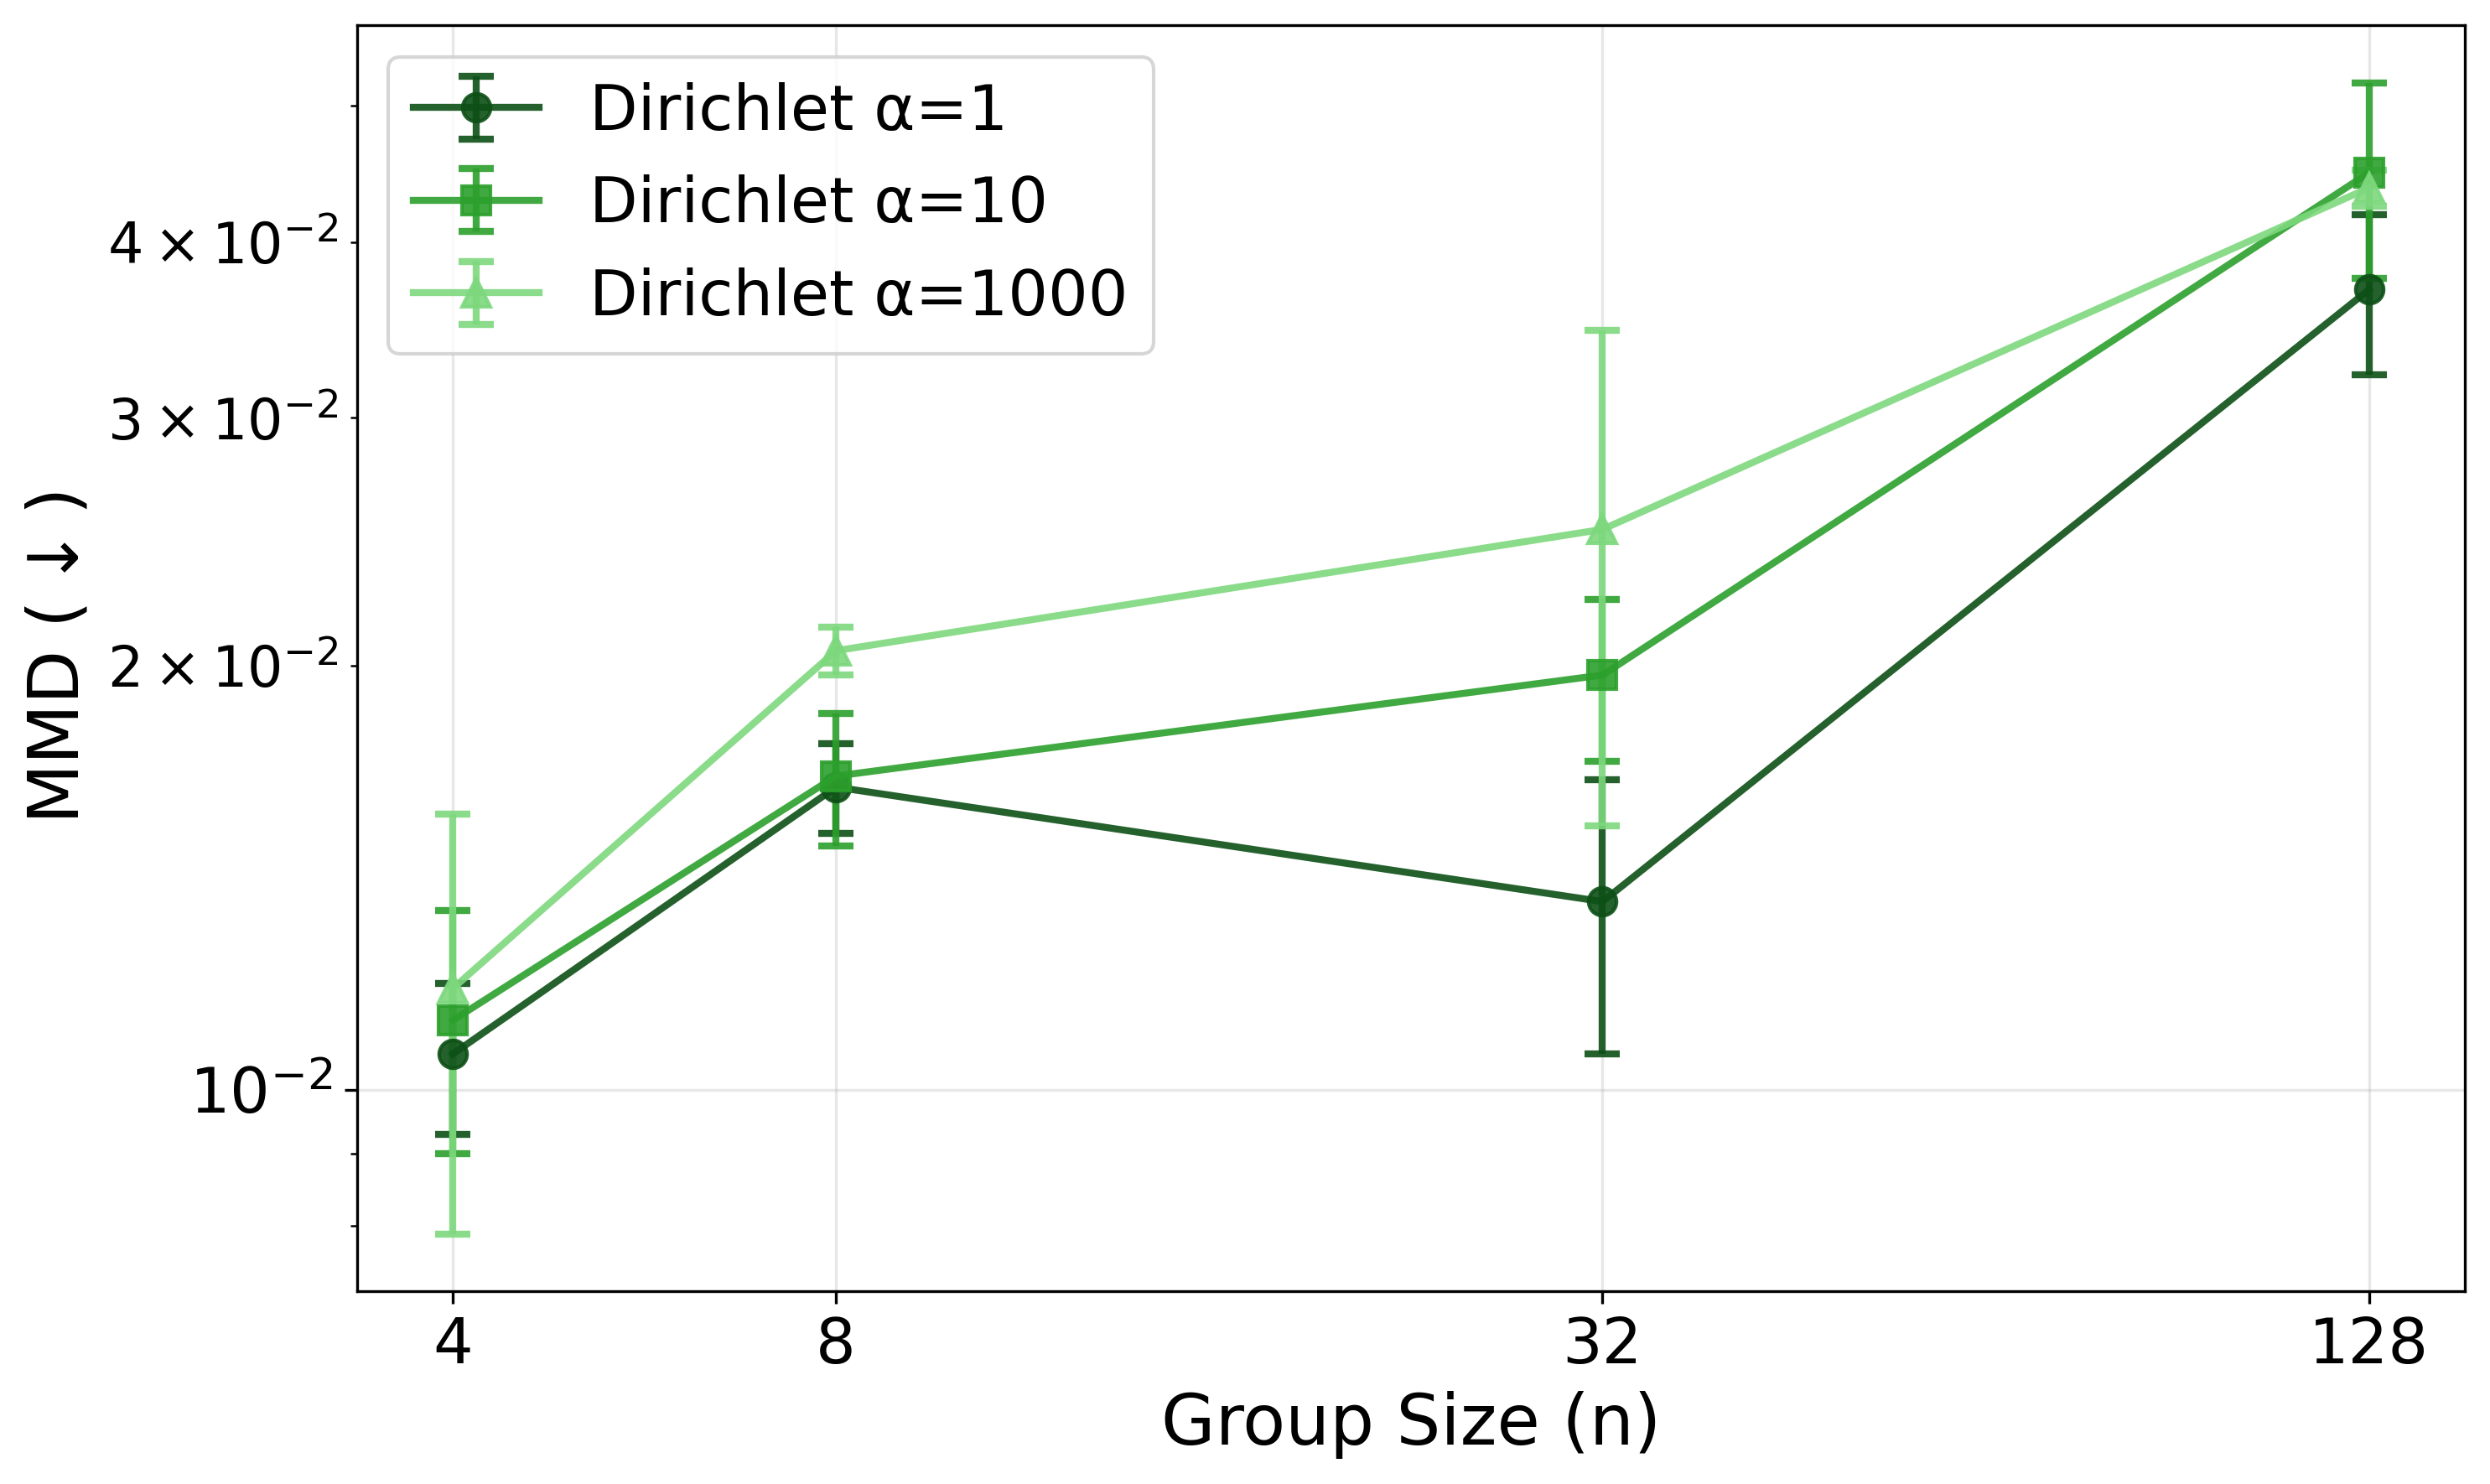

Line plot saved: figs/deconv_lineplot_mmd_rbf.png
Creating line plot for wasserstein...


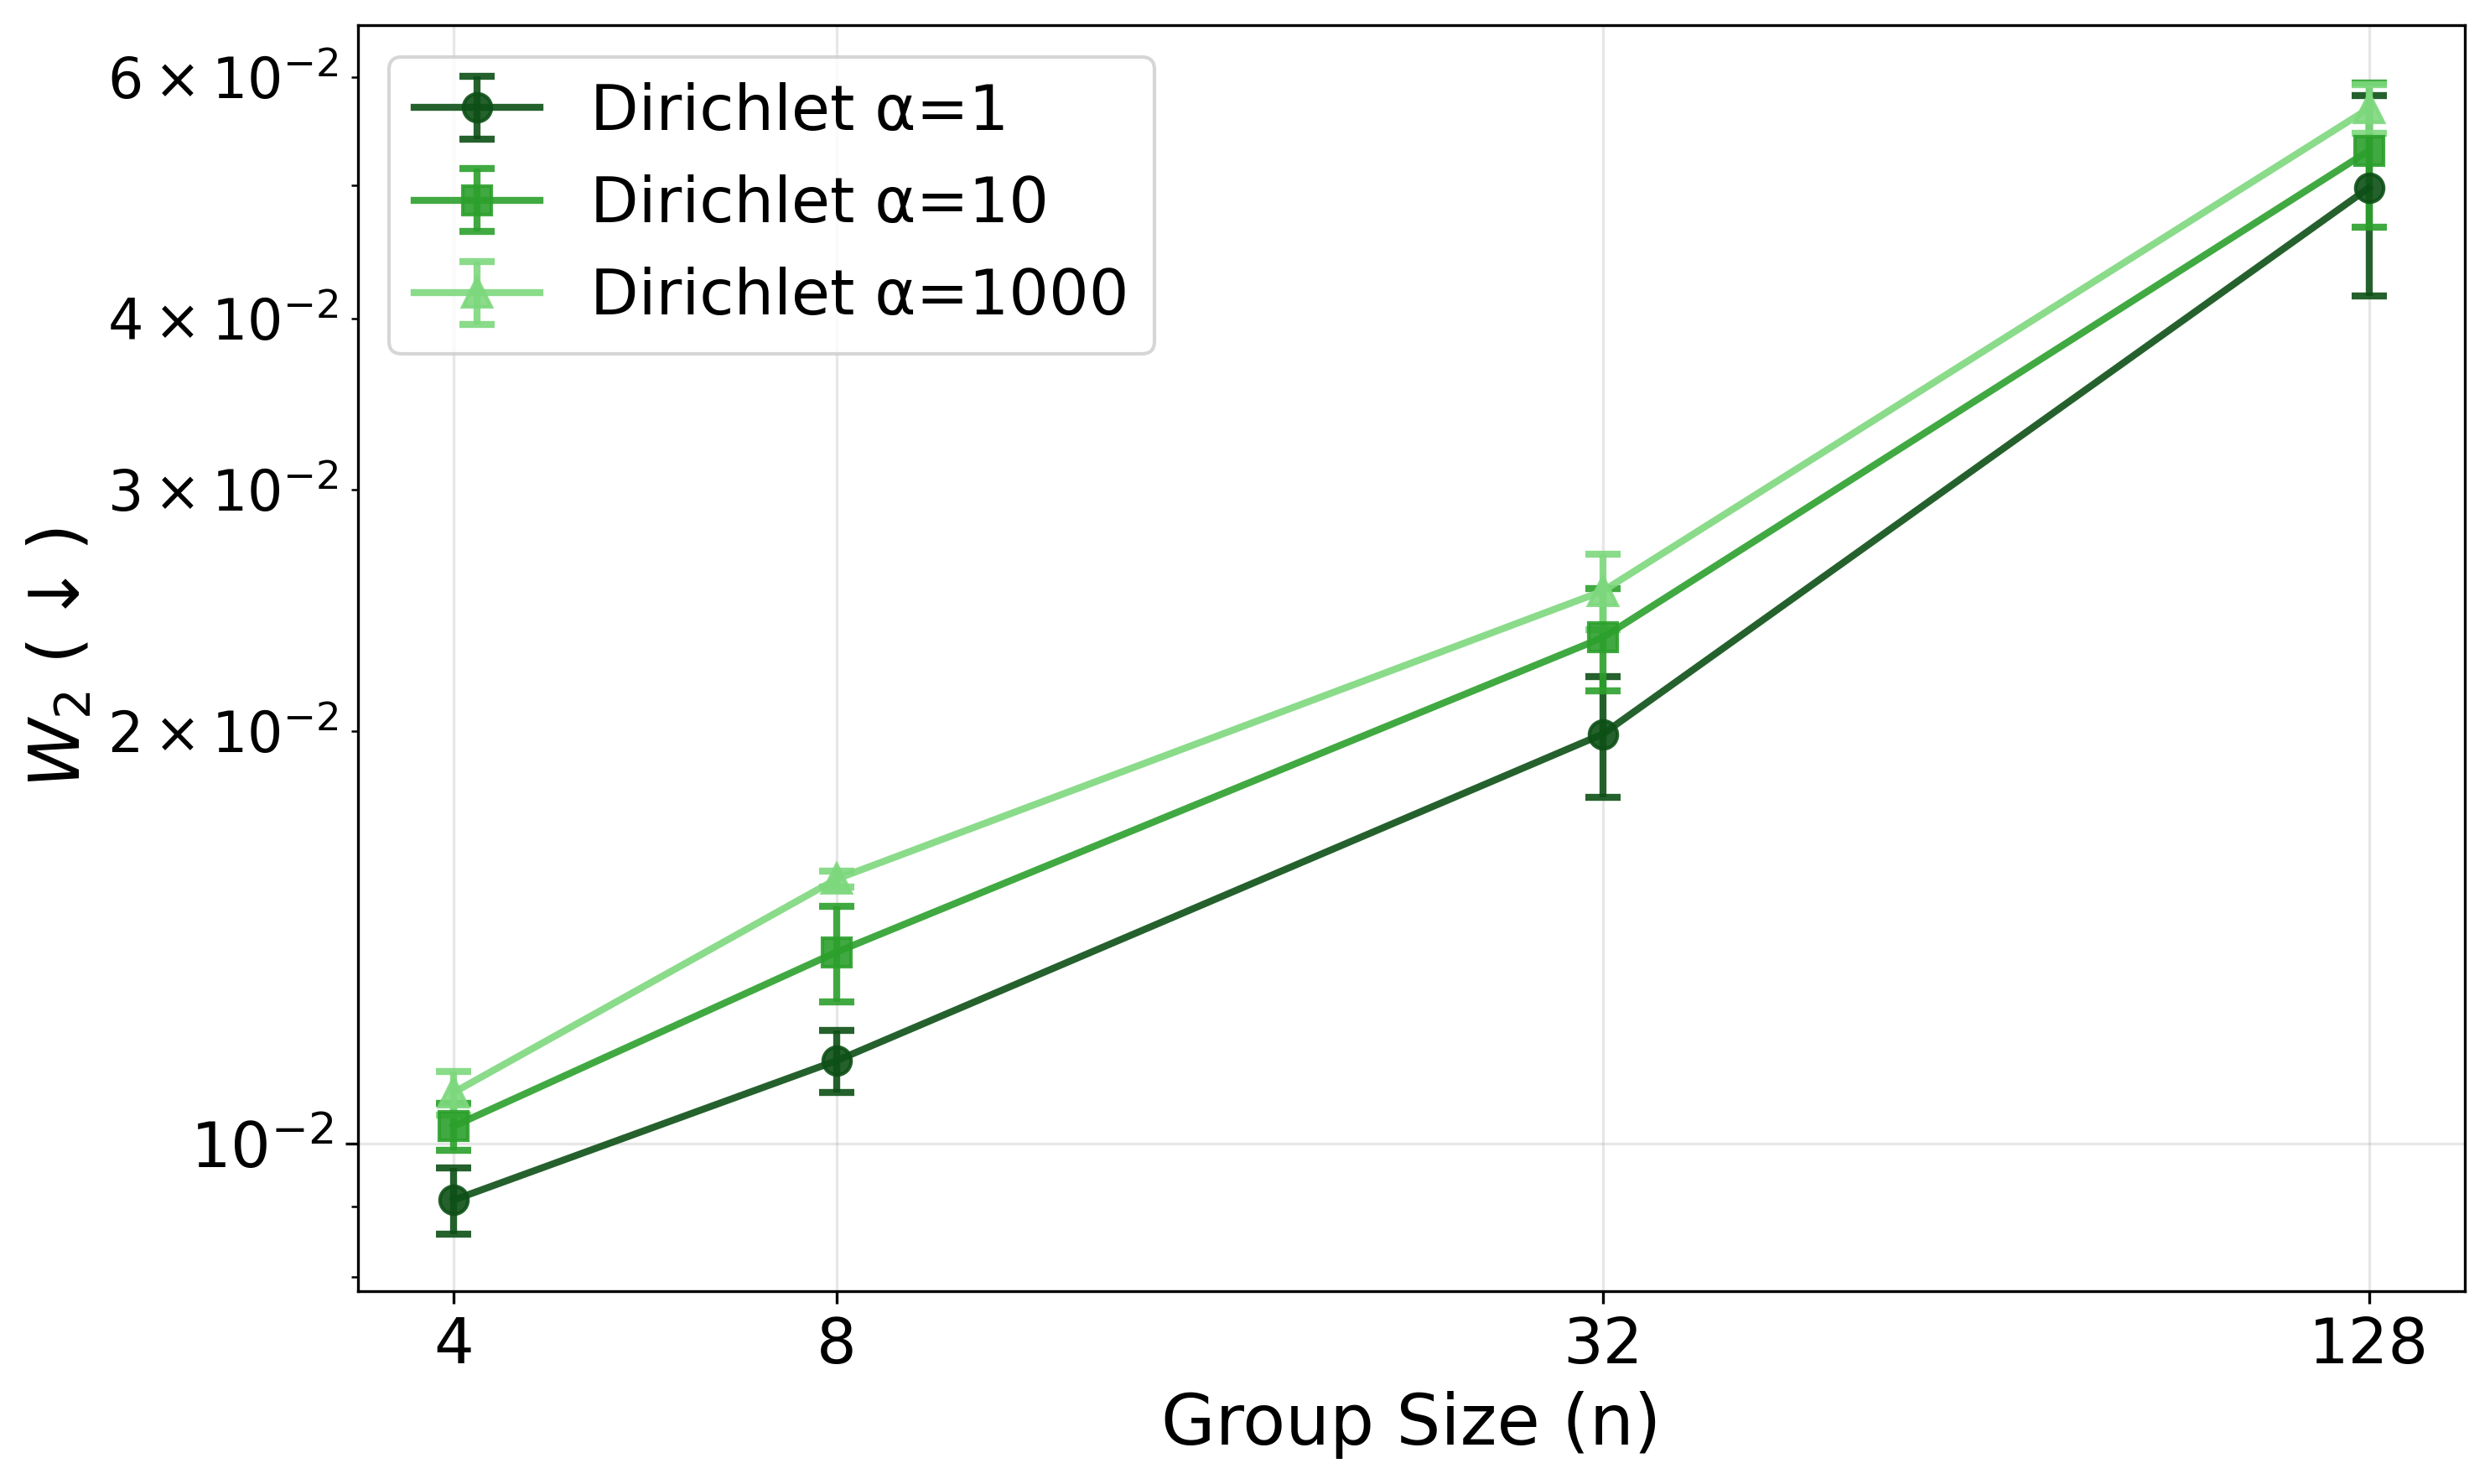

Line plot saved: figs/deconv_lineplot_wasserstein.png
Creating line plot for energy...


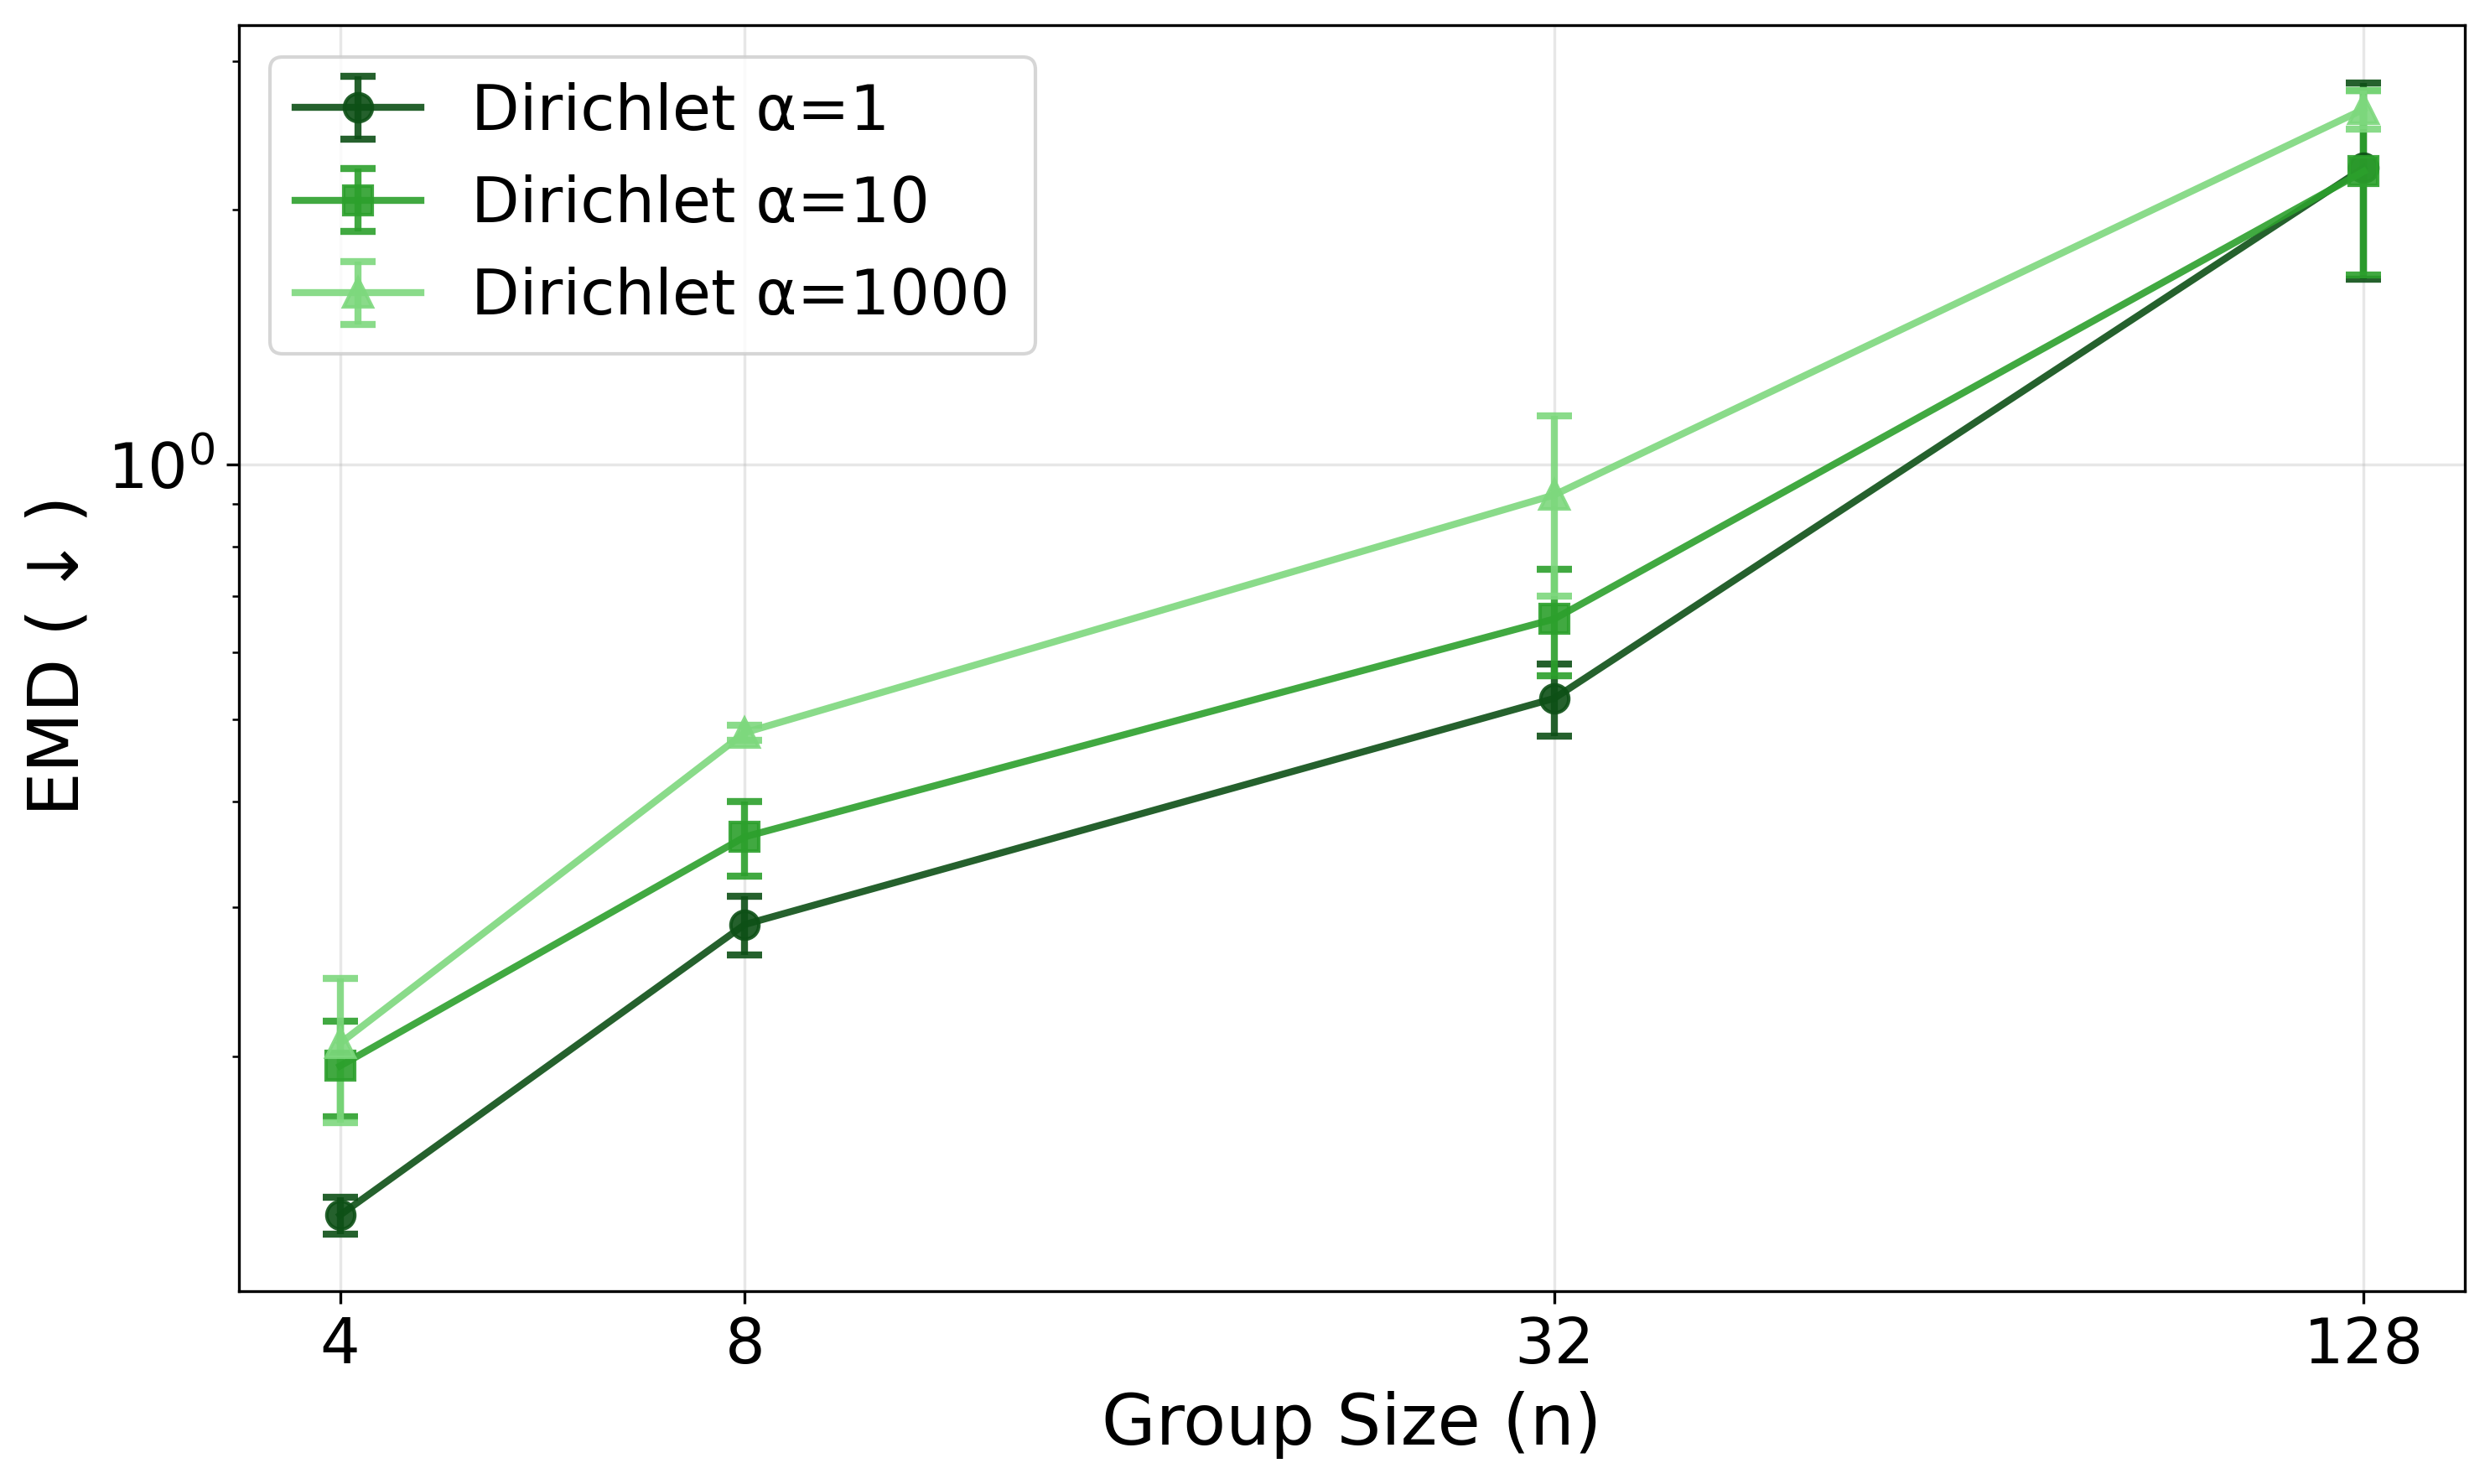

Line plot saved: figs/deconv_lineplot_energy.png


In [6]:
"""
Deconvolution experiments line plot visualization and table generation
Showing performance vs group size (n) for different Dirichlet concentrations
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuration
METRICS = {
    "mmd_rbf": ("mmd_rbf_mean", "mmd_rbf_std", "MMD"),
    "wasserstein": ("wasserstein_distance_mean", "wasserstein_distance_std", "$W_2$"),
    "energy": ("energy_distance_mean", "energy_distance_std", "EMD")
}

def create_line_plot(df, metric="mmd_rbf", save_dir="figs"):
    """Create line plot showing performance vs group size for different Dirichlet concentrations."""
    mean_col, std_col, metric_name = METRICS[metric]
    
    # Get unique values for axes
    group_sizes = sorted(df['group_size_mean'].unique())
    dirichlet_concentrations = sorted(df['dirichlet_concentration_mean'].unique())
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    
    # Green color palette for different concentrations (matching previous style)
    # Use different shades of green: darker for lower concentrations, lighter for higher
    green_colors = ['#0d5016', '#2ca02c', '#7dd87d']  # Dark green, medium green, light green
    markers = ['o', 's', '^', 'D', 'v', '<']
    
    for i, conc in enumerate(dirichlet_concentrations):
        # Get data for this concentration
        conc_data = df[df['dirichlet_concentration_mean'] == conc]
        
        # Sort by group size
        conc_data = conc_data.sort_values('group_size_mean')
        
        x = conc_data['group_size_mean']
        y = conc_data[mean_col]
        yerr = conc_data[std_col]
        
        # Plot line with error bars
        color = green_colors[i % len(green_colors)]
        marker = markers[i % len(markers)]
        
        ax.errorbar(x, y, yerr=yerr, 
                   color=color, marker=marker, markersize=8, linewidth=2,
                   capsize=5, capthick=2, 
                   label=f'Dirichlet α={int(conc)}', alpha=0.9)
    
    # Customize plot
    ax.set_xlabel('Group Size (n)', fontsize=20)
    ax.set_ylabel(f'{metric_name} ' + r'($\downarrow$)', fontsize=20)
    ax.set_xscale('log', base=2)  # Log scale for group sizes
    ax.set_yscale('log')  # Log scale for metrics
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=18)
    
    # Set tick label fontsize
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    
    # Set x-axis ticks to show actual group sizes
    ax.set_xticks(group_sizes)
    ax.set_xticklabels([str(int(gs)) for gs in group_sizes])
    
    plt.tight_layout()
    
    # Save figure
    Path(save_dir).mkdir(exist_ok=True)
    filename = f"{save_dir}/deconv_lineplot_{metric}.png"
    plt.savefig(filename, bbox_inches='tight', dpi=500)
    plt.show()
    print(f"Line plot saved: {filename}")

def create_all_plots(df):
    """Create line plots for all metrics."""
    print("Creating line plots for each metric...")
    for metric in METRICS.keys():
        print(f"Creating line plot for {metric}...")
        create_line_plot(df, metric)

# Create all plots
create_all_plots(df)


In [7]:
def create_individual_metric_tables(df, save_to_file=True):
    """Create separate compact LaTeX table for each metric showing n vs Dirichlet concentration."""
    
    # Create tables directory
    tables_dir = Path("tables")
    tables_dir.mkdir(exist_ok=True)
    
    # Get unique values
    group_sizes = sorted(df['group_size_mean'].unique())
    dirichlet_concentrations = sorted(df['dirichlet_concentration_mean'].unique())
    
    for metric_key, (mean_col, std_col, metric_name) in METRICS.items():
        lines = []
        lines.append("\\begin{table}[h!]")
        lines.append("\\centering")
        lines.append(f"\\caption{{Deconvolution Performance: {metric_name} vs Group Size and Dirichlet Concentration}}")
        lines.append(f"\\label{{tab:deconv_{metric_key}}}")
        
        # Dynamic table structure based on actual concentrations
        n_cols = len(dirichlet_concentrations) + 1  # +1 for group size column
        col_spec = "c" + "c" * len(dirichlet_concentrations)
        lines.append(f"\\begin{{tabular}}{{{col_spec}}}")
        lines.append("\\toprule")
        
        # Create header
        header = ["Group Size (n)"] + [f"$\\alpha={{{int(conc)}}}$" for conc in dirichlet_concentrations]
        lines.append(" & ".join(header) + " \\\\")
        lines.append("\\midrule")
        
        # Find best result for this metric
        best_val = float('inf')
        best_combo = None
        
        for group_size in group_sizes:
            for conc in dirichlet_concentrations:
                mask = (df['group_size_mean'] == group_size) & (df['dirichlet_concentration_mean'] == conc)
                filtered_data = df[mask]
                
                if not filtered_data.empty:
                    val = filtered_data.iloc[0][mean_col]
                    if val < best_val:
                        best_val = val
                        best_combo = (group_size, conc)
        
        # Fill table data
        for group_size in group_sizes:
            row = [str(int(group_size))]
            
            for conc in dirichlet_concentrations:
                mask = (df['group_size_mean'] == group_size) & (df['dirichlet_concentration_mean'] == conc)
                filtered_data = df[mask]
                
                if not filtered_data.empty:
                    row_data = filtered_data.iloc[0]
                    mean_val = row_data[mean_col]
                    std_val = row_data[std_col]
                    
                    # Format values
                    if mean_val < 0.001:
                        formatted_val = f"{mean_val:.2e} ± {std_val:.2e}"
                    elif mean_val < 0.01:
                        formatted_val = f"{mean_val:.4f} ± {std_val:.4f}"
                    elif mean_val < 1:
                        formatted_val = f"{mean_val:.3f} ± {std_val:.3f}"
                    else:
                        formatted_val = f"{mean_val:.2f} ± {std_val:.2f}"
                    
                    # Bold if this is the best result
                    if best_combo == (group_size, conc):
                        formatted_val = f"\\textbf{{{formatted_val}}}"
                    
                    row.append(formatted_val)
                else:
                    row.append("--")
            
            lines.append(" & ".join(row) + " \\\\")
        
        lines.append("\\bottomrule")
        lines.append("\\end{tabular}")
        lines.append("\\end{table}")
        
        if save_to_file:
            filename = tables_dir / f"deconv_{metric_key}.tex"
            with open(filename, 'w') as f:
                f.write('\n'.join(lines))
            print(f"{metric_name} table saved to: {filename}")
        else:
            print(f"{metric_name} Table:")
            print("=" * 30)
            for line in lines:
                print(line)
            print()

# Generate individual metric tables
print("Creating individual metric tables...")
create_individual_metric_tables(df, save_to_file=True)


Creating individual metric tables...
MMD table saved to: tables/deconv_mmd_rbf.tex
$W_2$ table saved to: tables/deconv_wasserstein.tex
EMD table saved to: tables/deconv_energy.tex


In [ ]:
# Analysis complete - all plots and tables generated
